# Clustering of Online Encyclopedia Data
Authors: Sakthi Kripa Selvan, Akshaya Mahesh

## Installing dependencies

In [ ]:
!pip install wikipedia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11695 sha256=c5549013780b16aea9d62aa5de7cc7ec4675a703115495ea23a45ee5797368ba
  Stored in directory: /root/.cache/pip/wheels/07/93/05/72c05349177dca2e0ba31a33ba4f7907606f7ddef303517c6a
Successfully built wikipedia


In [ ]:
### importing dependencies ###

import wikipedia
from wikipedia.exceptions import WikipediaException
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from wordcloud import WordCloud

## Extracting the text data

In [ ]:
# Topics chosen
topics = ["Northeastern Unversity", "Natural language processing", "Quantum machine learning", 
          "Artificial intelligence", "Data science", "Master in Data Science", 
          "European Central Bank", "Financial technology","International Monetary Fund", 
 "Basketball", "Swimming", "Football", "College Football", "Association Football", 
 "Christians", "Hindus", "Jesus", "World religions", "Conception of god", "Greenhouse effect", "Air pollution",
 "Climate change", "Batman", "Superman", "Flash", "Cyborg", "Facebook", "Telegram", "Instagram", "SnapChat", "WeChat", 
 "Diwali", "Pongal", "Christmas", "Thanksgiving"]
dataset_target = [0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7]

data=[]
for title in topics:
  try:
    data.append(wikipedia.page(title).content)
  except WikipediaException:
    print(f"error when searching for {title}")

In [ ]:
# Sample data
data[1]

'Natural language processing (NLP) is a subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language, in particular how to program computers to process and analyze large amounts of natural language data.  The goal is a computer capable of "understanding" the contents of documents, including the contextual nuances of the language within them. The technology can then accurately extract information and insights contained in the documents as well as categorize and organize the documents themselves.\nChallenges in natural language processing frequently involve speech recognition, natural-language understanding, and natural-language generation.\n\n\n== History ==\n\nNatural language processing has its roots in the 1950s. Already in 1950, Alan Turing published an article titled "Computing Machinery and Intelligence" which proposed what is now called the Turing test as a criterion of intelligence, though at the time

## Data Preprocessing

In [ ]:
# Cleaning function
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import string
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')



def clean_message(review):
 
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review. 

    '''
    # Converting the reviews to lowercase
    review_cleaned = review.lower()

    # Removing HTML patterns like <br />
    html_pattern = re.compile('<.*?>')
    review_cleaned = html_pattern.sub(r'', review_cleaned) 

    # Removing url's if any in the code
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    review_cleaned = url_pattern.sub(r'', review_cleaned)

    # List of stop words
    stop_words = set(stopwords.words('english')) 

    # Tokenizing the words while removing punctuations 
    tokenizer = RegexpTokenizer(r'\w+')
    tokenwords = tokenizer.tokenize(review_cleaned) 
    
    # Removing stop words using the list created above
    result = [] 
    for w in tokenwords: 
      if w not in stop_words: 
        result.append(w)
    
    # Lemmatizing the words
    # Performing lemmatization instead of suggested stemming as lemmatization improved the accuracy of the model
    lemmatizer = WordNetLemmatizer()
    review_cleaned = [lemmatizer.lemmatize(w) for w in result]

    ps = PorterStemmer()
    review_cleaned = [ps.stem(w) for w in review_cleaned]

    # Joining the list of words back into a string
    review_cleaned = " ".join(review_cleaned)

    return review_cleaned


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Cleaning the data
cleaned_data = []
for i in data:
  cleaned = clean_message(i)
  cleaned_data.append(cleaned)

In [ ]:
# Sample of cleaned data
cleaned_data[1]

'natural language processing nlp subfield linguistics computer science artificial intelligence concerned interaction computer human language particular program computer process analyze large amount natural language data goal computer capable understanding content document including contextual nuance language within technology accurately extract information insight contained document well categorize organize document challenge natural language processing frequently involve speech recognition natural language understanding natural language generation history natural language processing root 1950s already 1950 alan turing published article titled computing machinery intelligence proposed called turing test criterion intelligence though time articulated problem separate artificial intelligence proposed test includes task involves automated interpretation generation natural language symbolic nlp 1950s early 1990s premise symbolic nlp well summarized john searle chinese room experiment given

In [ ]:
# vectorize the dataset using tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vecs = TfidfVectorizer(stop_words={'english'})
X = vecs.fit_transform(cleaned_data)a

## Initial visulatization of data using dendogram

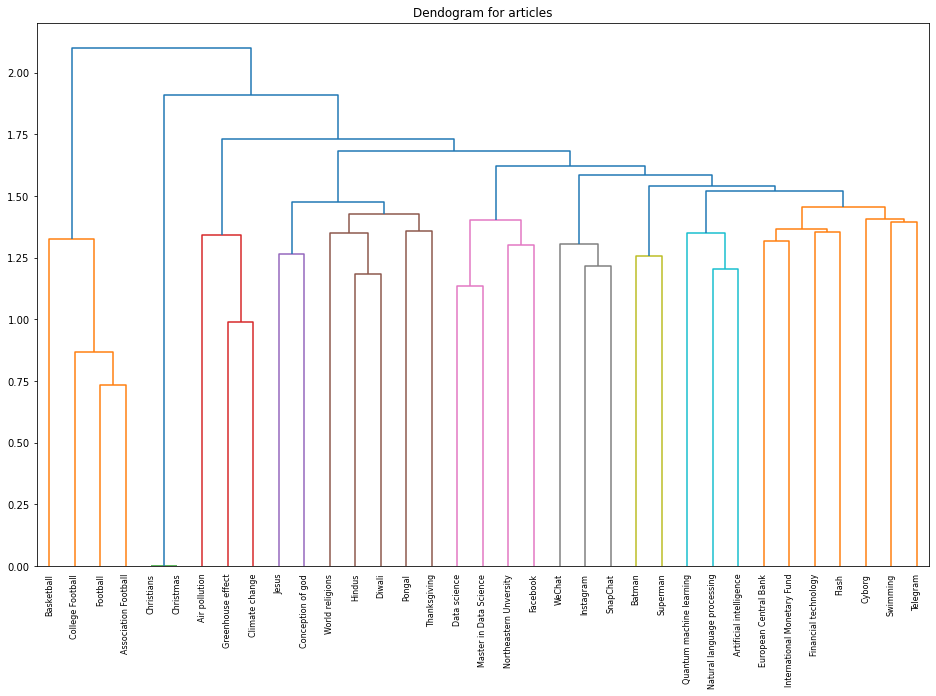

In [ ]:
# plot the dendrogram
plt.figure(figsize=(16, 10)) 
plt.title("Dendogram for articles")
dend = shc.dendrogram(shc.linkage(X.todense(), method='ward'),labels=topics, leaf_rotation=90.)
 

## Clustering Techniques

### Agglomerative clustering


In [ ]:
# Grid search cv on agglomerative clustering to select the best parameters

clustering = AgglomerativeClustering()
param_grid = {
   "linkage": ['ward', 'complete', 'average', 'single'],
   "affinity": ['euclidean', 'l1', 'l2', 'manhattan', 'cosine',],
}

def scorer(estimator, X, y=None):
    y_pred = estimator.fit_predict(X)
    return metrics.silhouette_score(X, y_pred)


grid = GridSearchCV(clustering, param_grid=param_grid, cv=5, scoring=scorer)
grid.fit(X.toarray())

In [ ]:
# Parameters selected using gridsearchCV
grid.best_params_

{'affinity': 'euclidean', 'linkage': 'ward'}

In [ ]:
# More performance metrics on the final metrics
ag_1 = AgglomerativeClustering(n_clusters = 8, affinity = 'euclidean', linkage = 'ward')
ag_1.fit(X.toarray())

print("Homogeneity: %0.3f" % metrics.homogeneity_score(dataset_target, ag_1.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(dataset_target, ag_1.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(dataset_target, ag_1.labels_))
print("Adjusted Rand Score: %0.3f" % metrics.adjusted_rand_score(dataset_target, ag_1.labels_))
print("Silhouette Coefficient: %0.7f"
      % metrics.silhouette_score(X, ag_1.labels_))

Homogeneity: 0.673
Completeness: 0.719
V-measure: 0.695
Adjusted Rand Score: 0.350
Silhouette Coefficient: 0.1203161


### DBScan Algorithm

In [ ]:
db = DBSCAN(eps=0.5,min_samples=3).fit(X)
db.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1])

In [ ]:
db = DBSCAN(eps=1,min_samples=3).fit(X)
db.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1])

In [ ]:
db = DBSCAN(eps=1,min_samples=4).fit(X)
db.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1])

In [ ]:
db = DBSCAN(eps=1,min_samples=1).fit(X)
db.labels_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 11, 11, 12, 13, 14,
       15, 16, 17, 18, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 12,
       30])

We fit the DBScan algorithm for our data. But since the data is small and spread out we were not able to form clusters. The DBScan algorithm is a density based algorithm and does not work well with sparse data. After testing out various values for the hyper-parameters eps and min_samples we have rules out the dbscan algorithm fo our data. But DBscan is one of the best suited algorithm for text data and can be tested with larger data.

### Spectral clustering

In [ ]:
sc_1 = SpectralClustering(n_clusters=8,random_state = 123, eigen_solver = 'arpack', affinity='nearest_neighbors')
sc_1.fit(X.toarray())

print("Silhouette Coefficient: %0.7f"
      % metrics.silhouette_score(X, sc_1.labels_))


Silhouette Coefficient: 0.0606119


In [ ]:
sc_2 = SpectralClustering(n_clusters=8,random_state = 123, affinity='rbf')

sc_2.fit(X.toarray())
print("Silhouette Coefficient: %0.7f"
      % metrics.silhouette_score(X, sc_2.labels_))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(dataset_target, sc_2.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(dataset_target, sc_2.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(dataset_target, sc_2.labels_))
print("Adjusted Rand Score: %0.3f" % metrics.adjusted_rand_score(dataset_target, sc_2.labels_))

Silhouette Coefficient: 0.1184854
Homogeneity: 0.607
Completeness: 0.664
V-measure: 0.634
Adjusted Rand Score: 0.237


Keepping the clusters as 8 and affinity as rbf we are able to get a silhouette score of 0.11 which is better than the affinity method 'nearest_neighbors'

### K-means

In [ ]:
km_1 = KMeans(n_clusters = 8, algorithm = 'auto', init = 'k-means++', random_state= 101 )
km_1.fit(X)
print("Silhouette Coefficient: %0.7f"
      % metrics.silhouette_score(X, km_1.labels_))

Silhouette Coefficient: 0.0812234


In [ ]:
km_3 = KMeans(n_clusters = 8, algorithm = 'full', init = 'random', random_state= 101 )
km_3.fit(X)
print("Silhouette Coefficient: %0.7f"
      % metrics.silhouette_score(X, km_3.labels_))

Silhouette Coefficient: 0.0671650


In [ ]:
km_2 = KMeans(n_clusters = 8, algorithm = 'full', init = 'k-means++', random_state= 101 )
km_2.fit(X)
print("Silhouette Coefficient: %0.7f"
      % metrics.silhouette_score(X, km_2.labels_))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(dataset_target, km_2.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(dataset_target, km_2.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(dataset_target, km_2.labels_))
print("Adjusted Rand Score: %0.3f" % metrics.adjusted_rand_score(dataset_target, km_2.labels_))

Silhouette Coefficient: 0.0812234
Homogeneity: 0.678
Completeness: 0.699
V-measure: 0.688
Adjusted Rand Score: 0.365


## Best clustering model

From the Silhouette score we can say that of the clustering algorithms, Agglomerative clustering algorithm performs the best. Its homogenity score, completeness score, V-measure score and Adjusted Rand score are also better than the other algorithms. Spectral clustering also follows closely behind. \
Below is the chosen agglomerative model with its hyper parameters:

In [ ]:
# Best model
ag_1 = AgglomerativeClustering(n_clusters = 8, affinity = 'euclidean', linkage = 'ward')
ag_1.fit(X.toarray())

print("Homogeneity: %0.3f" % metrics.homogeneity_score(dataset_target, ag_1.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(dataset_target, ag_1.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(dataset_target, ag_1.labels_))
print("Adjusted Rand Score: %0.3f" % metrics.adjusted_rand_score(dataset_target, ag_1.labels_))
print("Silhouette Coefficient: %0.7f"
      % metrics.silhouette_score(X, ag_1.labels_))

Homogeneity: 0.673
Completeness: 0.719
V-measure: 0.695
Adjusted Rand Score: 0.350
Silhouette Coefficient: 0.1203161


Cluster: 0
Titles
Natural language processing
   Quantum machine learning
    Artificial intelligence
      European Central Bank
       Financial technology
International Monetary Fund
                   Swimming
                      Flash
                     Cyborg
                   Telegram


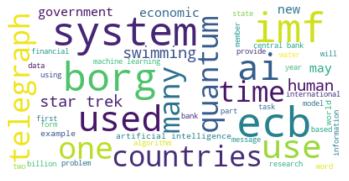

Cluster: 1
Titles
           Hindus
            Jesus
  World religions
Conception of god
           Diwali
           Pongal
     Thanksgiving


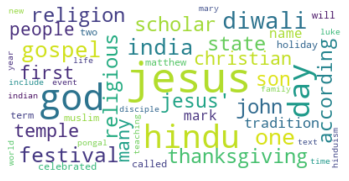

Cluster: 2
Titles
Northeastern Unversity
          Data science
Master in Data Science
              Facebook


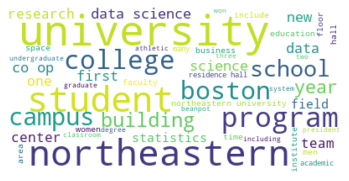

Cluster: 3
Titles
          Basketball
            Football
    College Football
Association Football


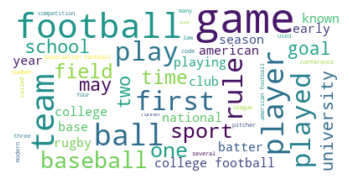

Cluster: 4
Titles
Greenhouse effect
    Air pollution
   Climate change


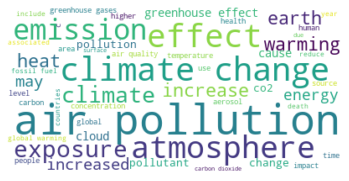

Cluster: 5
Titles
Christians
 Christmas


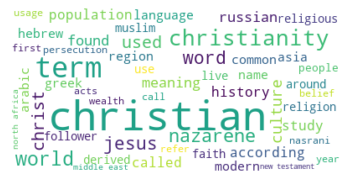

Cluster: 6
Titles
Instagram
 SnapChat
   WeChat


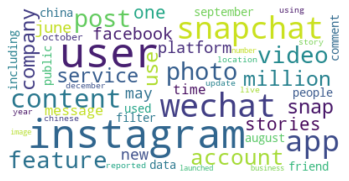

Cluster: 7
Titles
  Batman
Superman


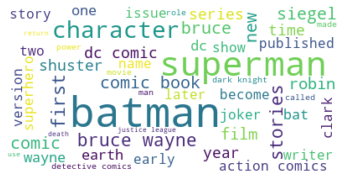

In [ ]:
# Word cloud to visualiza the most important words in each cluster
labels=ag_1.labels_
wiki_cl=pd.DataFrame(list(zip(topics,labels)),columns=['title','cluster'])

result={'cluster':labels,'wiki':data}
result=pd.DataFrame(result)
for k in range(0,8):
   s=result[result.cluster==k]
   text=s['wiki'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   print('Titles')
   titles=wiki_cl[wiki_cl.cluster==k]['title']         
   print(titles.to_string(index=False))
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show() 